In [1]:
#author:vincent
#所需库
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import copy
import os
import torch.utils.data as data
import random
import csv
import operator
import time

In [2]:
def toInt(array):
    array=np.mat(array)
    m,n=np.shape(array)
    newArray=np.zeros((m,n))
    for i in xrange(m):
            for j in xrange(n):
                newArray[i,j]=int(array[i,j])
    return newArray
def normalize(array):
    m,n=np.shape(array)
    for i in xrange(m):
        for j in xrange(n):
            if array[i][j]!=0:
                array[i][j]=1
    return array
#从csv中载入训练集和测试集
def LoadTrainData(filepath):
    l=[]
    with open(filepath) as f:
        lines=csv.reader(f)
        for line in lines:
            l.append(line)
    l.remove(l[0])
    i=np.array(l)
    lable=i[:,0]
    data=i[:,1:]
    return normalize(toInt(data)),toInt(lable)
def LoadTestData(filepath):
    l=[]
    with open(filepath) as f:
        lines=csv.reader(f)
        for line in lines:
            l.append(line)
    l.remove(l[0])
    data=np.array(l)
    return normalize(toInt(data))

In [3]:
#建立数据集：其中包括训练数据和验证数据
class Dataset(data.Dataset):
    def __init__(self,root,transform=None,phase=None,ratio=0.7):
        self.root=root
        numbers,labels=LoadTrainData(self.root)
        labels=labels[0]
        if phase=='train':
            self.numbers=numbers[:int(len(numbers)*ratio)]
            self.label=labels[:int(len(numbers)*ratio)]
        elif phase=='val':
            self.numbers=numbers[int(len(numbers)*ratio)+1:]
            self.label=labels[int(len(numbers)*ratio)+1:]
        else:
            raise(RuntimeError("phase is wrong"))

        self.phase=phase
        self.transform=transform
    def __getitem__(self,idx):
        number=self.numbers[idx]
        label=self.label[idx]
        #原数据为（1,784）
        number=number.reshape((28,28))
        number=np.expand_dims(number,0)
        number=torch.from_numpy(number)
        number=number.type(torch.FloatTensor)
        return number,label
    def __len__(self):
        return len(self.numbers)
        

In [4]:
#训练所用网络模型：
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*4*4, 120) # an affine operation: y = Wx + b
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # If the size is a square you can only specify a single number
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = Net().cuda()
print(model)

Net (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (256 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [5]:
#训练函数
def train_model(model, criterion, optimizer, num_epochs=20):
    since = time.time()

    best_model = model
    best_acc = 0.0
    train_acc=[]
    val_acc=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = optimizer

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data
                labels=labels.type(torch.LongTensor)
                #print(type(labels))
                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                #print type(outputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds== labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = float(running_corrects) / float(dset_sizes[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase=='train':
                train_acc.append(epoch_acc)
            if phase=='val':
                val_acc.append(epoch_acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model,train_acc,val_acc

def optim_scheduler_ft(model, epoch, init_lr=0.001, lr_decay_epoch=5):
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=lr)
    return optimizer

In [6]:
#载入数据集
train_path='./train.csv'
dset={x:Dataset(train_path,phase=x) for x in ['train','val']}
dset_loaders={x:torch.utils.data.DataLoader(dset[x],batch_size=16,shuffle=True,num_workers=4) for x in ['train','val']}
dset_sizes = {x: len(dset[x]) for x in ['train', 'val']}
dset_classes =dset['val'].label
print (dset_sizes)
print (len(dset_classes))
use_gpu = torch.cuda.is_available()

{'train': 29399, 'val': 12600}
12600


In [7]:
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [8]:
num_epochs=15
model,train_acc,val_acc = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.0970 Acc: 0.4886
val Loss: 0.0229 Acc: 0.8822
Epoch 1/14
----------
train Loss: 0.0169 Acc: 0.9153
val Loss: 0.0110 Acc: 0.9439
Epoch 2/14
----------
train Loss: 0.0101 Acc: 0.9499
val Loss: 0.0099 Acc: 0.9506
Epoch 3/14
----------
train Loss: 0.0078 Acc: 0.9603
val Loss: 0.0069 Acc: 0.9672
Epoch 4/14
----------
train Loss: 0.0065 Acc: 0.9672
val Loss: 0.0063 Acc: 0.9694
Epoch 5/14
----------
train Loss: 0.0055 Acc: 0.9719
val Loss: 0.0054 Acc: 0.9730
Epoch 6/14
----------
train Loss: 0.0049 Acc: 0.9749
val Loss: 0.0050 Acc: 0.9761
Epoch 7/14
----------
train Loss: 0.0043 Acc: 0.9770
val Loss: 0.0053 Acc: 0.9739
Epoch 8/14
----------
train Loss: 0.0038 Acc: 0.9805
val Loss: 0.0048 Acc: 0.9768
Epoch 9/14
----------
train Loss: 0.0036 Acc: 0.9816
val Loss: 0.0044 Acc: 0.9790
Epoch 10/14
----------
train Loss: 0.0032 Acc: 0.9834
val Loss: 0.0048 Acc: 0.9764
Epoch 11/14
----------
train Loss: 0.0030 Acc: 0.9835
val Loss: 0.0045 Acc: 0.9798
Epoch 12/14
--

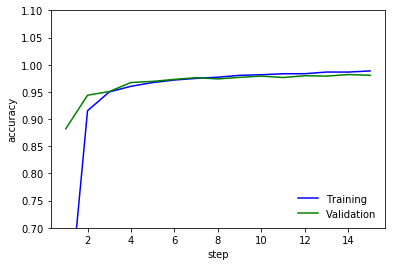

In [10]:
x_range=range(1,num_epochs+1)
plt.plot(x_range, train_acc,'-b', label='Training')
plt.plot(x_range, val_acc,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.show()

In [11]:
#保存训练好的模型
torch.save(model, 'digital_model_epoch10.pth')

/home/gcc/anaconda2/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [12]:
#保存测试结果，得到的是lable数组
def saveResult(result):
    with open('result.csv','wb') as myFile:    
        myWriter=csv.writer(myFile)
        for i in result:
            tmp=[]
            tmp.append(i)
            myWriter.writerow(tmp)

In [13]:
#把结果转成提交格式
def result2sub(sub_path):
    with open('result.csv','rb') as f:
        lines=csv.reader(f)
        a=[]
        count=1
        a.append(['ImageId','Label'])
        for line in lines:
            a.append([count,int(float(line[0]))])
            count=count+1
    with open(sub_path,'wb') as f:
        writer=csv.writer(f)
        for i in a:
            temp=[]
            temp.append(i[0])
            temp.append(i[1])
            writer.writerow(temp)

In [14]:
#测试结果
def Test(model,test_nums):
    result=[]
    for i in range(len(test_nums)):
        number=test_nums[i]
        number=number.reshape((28,28))
        number=np.expand_dims(number,0)
        number=np.expand_dims(number,0)
        number=torch.from_numpy(number)
        inputs=number.type(torch.FloatTensor)
        if use_gpu:
            inputs = Variable(inputs.cuda())
        outputs=model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds=int(preds.cpu().numpy())
        result.append(preds)
    return result

In [15]:
#测试：
test_path='./test.csv'
test_nums=LoadTestData(test_path)
result=Test(model,test_nums)
saveResult(result)

In [16]:
#转成提交格式
sub_path='./submission_lenet2.csv'
result2sub(sub_path)

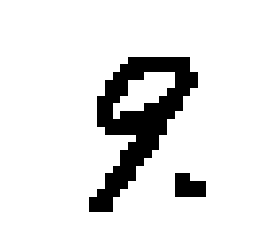

In [23]:
number=test_nums[2]
number=number.reshape((28,28))
plt.axis('off')
plt.imshow(number, cmap=cm.binary)